In [41]:
# import standard libraries
#!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# import our libraries
import bayes_helpers as bh
from utils import generate_data
from utils import run_toy_nn
from feed_forward import Feedforward
from nlm import NLM

from optimizers import *

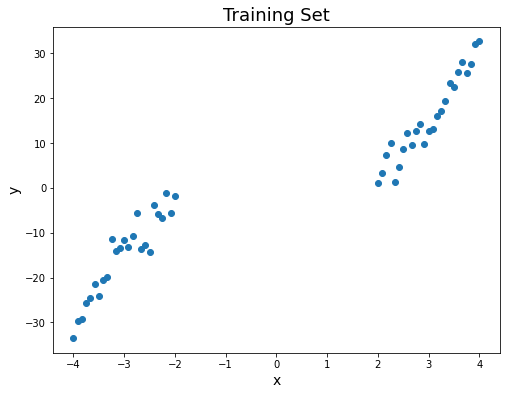

In [42]:
# Randomly generate a training set of 50 data points
number_of_points = 50
x_train, y_train, x_test = generate_data(number_of_points)

# Create a plot of the training set
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(x_train.flatten(), y_train.flatten())
ax.set_xlabel('x', fontsize = 14)
ax.set_ylabel('y', fontsize = 14)
plt.title('Training Set', fontsize = 18);

### Objective Function Output (MSE) Across Optimizers

In [43]:
# Define a function that sets the architecture for the NN
def set_architecture(width, hidden_layers, input_dim, output_dim, activation_fn_type, activation_fn):
    architecture = {'width': width,
                    'hidden_layers': hidden_layers,
                    'input_dim': input_dim,
                    'output_dim': output_dim,
                    'activation_fn_type': activation_fn_type,
                    'activation_fn_params': 'rate=1',
                    'activation_fn': activation_fn}
    return architecture 

#### Define the NLM

In [44]:
import bayes_helpers as bh

In [45]:
# Define the relu activation function
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


# Define the neural network model parameters
width = 20
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = set_architecture(width, hidden_layers, input_dim, output_dim, activation_fn_type, activation_fn)

In [46]:
# Set the paramters
prior_var = 1.0
y_var = 2.0
regularization_param_nlm = 5

# Initialize the NLM
nlm = NLM(prior_var, y_var, regularization_param_nlm, architecture, random_state = np.random.RandomState(0))

#### Define a function that returns the optimal weights and objective trace for a list of optimizers

In [67]:
# Define a function that produces the optimal weights and objective trace for each optimizer
def compute_objective_trace(nlm, optimizer_list):
    
    # Initialize a list used to store the optimal weights, objective traces, and number of iterations
    weights_list,objective_trace_list,num_iterations_list = [],[],[]
    
    # Iterate over each optimizer
    for optimizer_function in optimizer_list:

        # Set the parameters
        params = {'max_iteration': 5000, 
                  'random_restarts': 3,
                  'optimizer': optimizer_function}

        # Fit the NLM to the training set
        nlm.train(x_train, y_train, params)
        # Pull the optimal weights and objective trace
        weights = nlm.ff.weights
        trace = nlm.ff.objective_trace
        
        weights_list.append(weights)
        objective_trace_list.append(trace)
        num_iterations_list.append(len(trace))
        
    return weights_list,objective_trace_list,num_iterations_list

In [68]:
# Compute the objective trace for each optimizer
optimizer_list = [steepest_descent, BFGS, conjugate_gradient]
weights_list,objective_trace_list,num_iterations_list = compute_objective_trace(nlm, optimizer_list)

# Pull the final MSE and number of iterations for each optimizer
steepest_mse,steepest_iter = objective_trace_list[0][-1],num_iterations_list[0]
BFGS_mse,BFGS_iter = objective_trace_list[1][-1],num_iterations_list[1]
conjugate_mse,conjugate_iter = objective_trace_list[2][-1],num_iterations_list[2]

print(f"The MSE and number of iterations for steepest descent are {steepest_mse:0.4f} and {steepest_iter} respectively.")
print(f"The MSE and number of iterations for BFGS are {BFGS_mse:0.4f} and {BFGS_iter} respectively.")
print(f"The MSE and number of iterations for conjugate gradient are {conjugate_mse:0.4f} and {conjugate_iter} respectively.")


Done Training

Done Training


/Users/VICTOR/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/VICTOR/anaconda3/lib/python3.6/site-packages/autograd/numpy/linalg.py:89: RuntimeWarning: invalid value encountered in true_divide
  return expand(g / ans) * x



Done Training
The MSE and number of iterations for steepest descent are 48.2064 and 5001 respectively.
The MSE and number of iterations for BFGS are 48.2064 and 5001 respectively.
The MSE and number of iterations for conjugate gradient are 45.0763 and 1018 respectively.


In [53]:
# Create a dataframe that stores the performance metrics for each optimizer
optimizer_names = ['steepest descent', 'BFGS', 'conjugate gradient']

performance_df = pd.DataFrame({'optimizer': optimizer_names, 
                               'MSE': [steepest_mse,BFGS_mse,conjugate_mse],
                               'number of iterations': num_iterations_list})
performance_df

,optimizer,MSE,number of iterations
0,steepest descent,52.522804,5001
1,BFGS,52.522804,5001
2,conjugate gradient,317.414112,33


### Plots of MSE vs Iteration

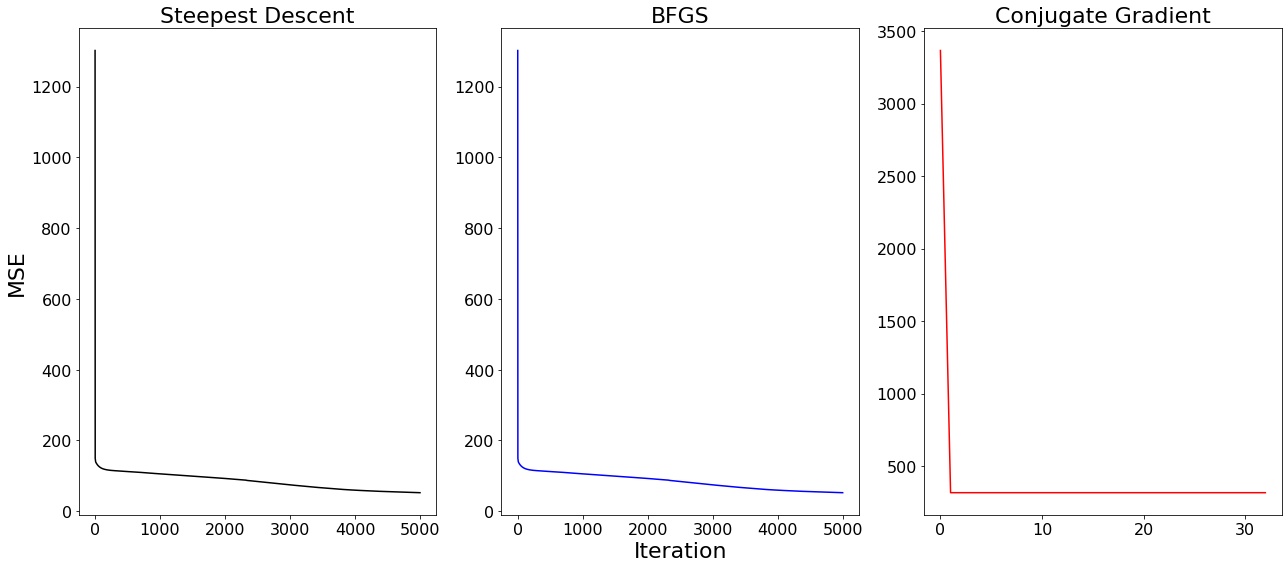

In [62]:
# Plot the objective trace for each optimizer
fig, axes = plt.subplots(1,3,figsize = (18,8))
ax = axes.flatten()
ax[0].plot(np.arange(0,num_iterations_list[0],1), objective_trace_list[0], 'black')
ax[0].set_ylabel('MSE', fontsize = 22)
ax[0].set_title('Steepest Descent', fontsize = 22)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].plot(np.arange(0,num_iterations_list[1],1), objective_trace_list[1], 'blue')
ax[1].set_xlabel('Iteration', fontsize = 22)
ax[1].set_title('BFGS', fontsize = 22)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[2].plot(np.arange(0,num_iterations_list[2],1), objective_trace_list[2], 'red')
ax[2].set_title('Conjugate Gradient', fontsize = 22)
ax[2].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout();

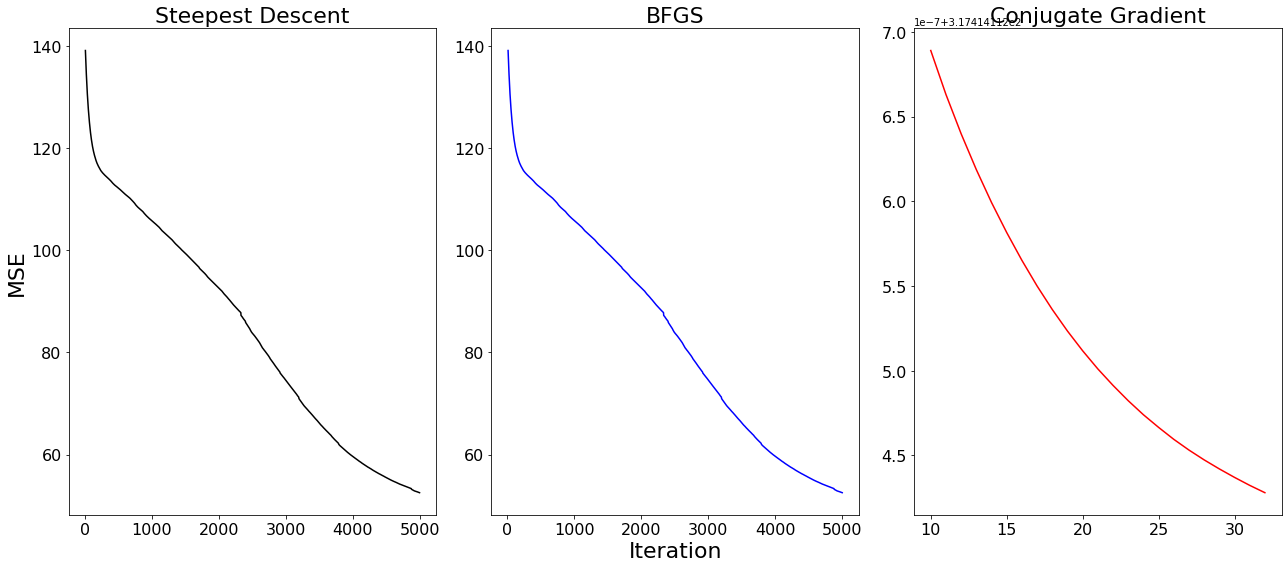

In [64]:
# Plot the objective trace for each optimizer (the first 10 iterations are removed)
fig, axes = plt.subplots(1,3,figsize = (18,8))
ax = axes.flatten()
ax[0].plot(np.arange(10,num_iterations_list[0],1), objective_trace_list[0][10:], 'black')
ax[0].set_ylabel('MSE', fontsize = 22)
ax[0].set_title('Steepest Descent', fontsize = 22)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].plot(np.arange(10,num_iterations_list[1],1), objective_trace_list[1][10:], 'blue')
ax[1].set_xlabel('Iteration', fontsize = 22)
ax[1].set_title('BFGS', fontsize = 22)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[2].plot(np.arange(10,num_iterations_list[2],1), objective_trace_list[2][10:], 'red')
ax[2].set_title('Conjugate Gradient', fontsize = 22)
ax[2].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout();

### Plots of True Data and Predictions

In [69]:
rand_state = 0
random = np.random.RandomState(rand_state)

# Instantiate the FeedForward object
nn = Feedforward(architecture, random=random)

# Compute predictions for each optimizer
steepest_pred = nn.forward(weights_list[0], x_test, final_layer_out=False)
BFGS_pred = nn.forward(weights_list[1], x_test, final_layer_out=False)
conjugate_pred = nn.forward(weights_list[2], x_test, final_layer_out=False)

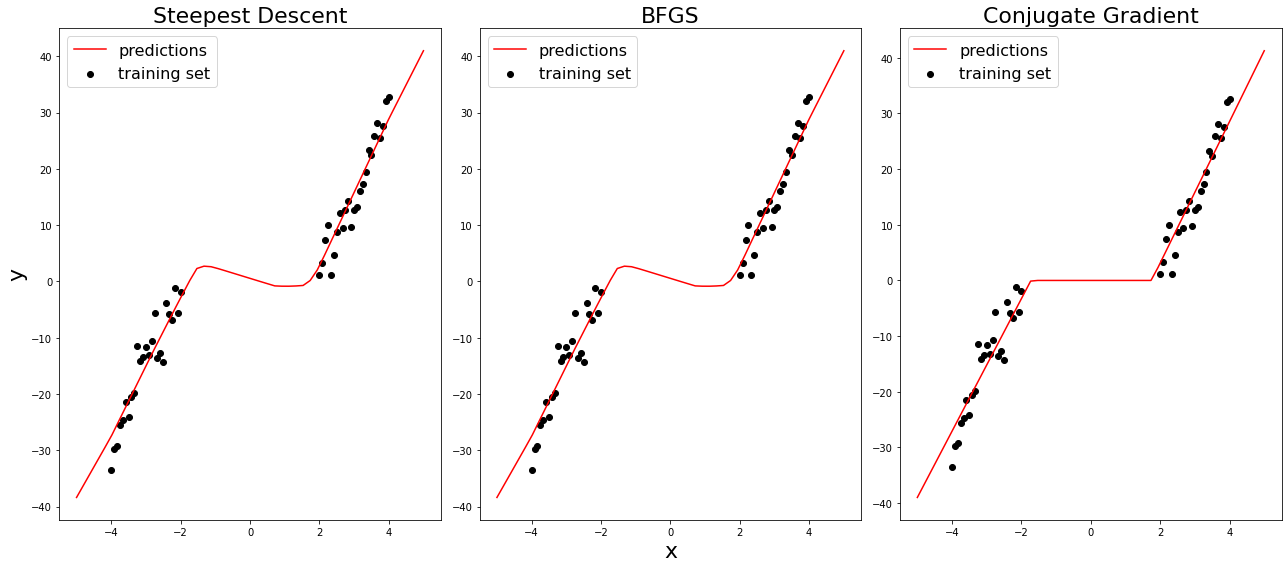

In [71]:
# Create a plot of the training set and NN predictions
fig, axes = plt.subplots(1,3,figsize = (18,8))
ax = axes.flatten()
ax[0].scatter(x_train[0], y_train[0], c='k', label='training set')
ax[0].plot(x_test[0], steepest_pred.flatten(), c='r', label='predictions')
ax[0].set_ylabel('y', fontsize = 22)
ax[0].set_title('Steepest Descent', fontsize = 22)
ax[0].legend(fontsize=16)
ax[1].scatter(x_train[0], y_train[0], c='k', label='training set')
ax[1].plot(x_test[0], BFGS_pred.flatten(), c='r', label='predictions')
ax[1].set_xlabel('x', fontsize = 22)
ax[1].set_title('BFGS', fontsize = 22)
ax[1].legend(fontsize=16)
ax[2].scatter(x_train[0], y_train[0], c='k', label='training set')
ax[2].plot(x_test[0], conjugate_pred.flatten(), c='r', label='predictions')
ax[2].set_title('Conjugate Gradient', fontsize = 22)
ax[2].legend(fontsize=16)
plt.tight_layout();